In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
class CNN(layers.Layer):
    def __init__(self, units, kernel_size, strides, padding):
        super(CNN, self).__init__()
        self.cnn = layers.Conv2D(filters=units, kernel_size=kernel_size, strides=strides, padding=padding)
        self.bn = layers.BatchNormalization()
    
    def call(self, x, training=False):
        x = self.cnn(x)
        x = self.bn(x, training=training)
        x = tf.nn.relu(x)
        return x

In [3]:
class model64(keras.Model):
    def __init__(self):
        super(model64, self).__init__()
        self.layer1 = CNN(units=128, kernel_size=2, strides=1, padding='same')
        self.layer2 = layers.MaxPool2D(pool_size=(2, 2))
        self.layer3 = layers.Dropout(rate=0.3)
        self.layer4 = CNN(units=80, kernel_size=3, strides=1, padding='same')
        self.layer5 = layers.MaxPool2D(pool_size=(2, 2))
        self.layer6 = CNN(units=60, kernel_size=3, strides=1, padding='same')
        self.layer7 = layers.MaxPool2D(pool_size=(2, 2))
        self.layer8 = CNN(units=50, kernel_size=3, strides=1, padding='same')
        self.layer9 = layers.MaxPool2D(pool_size=(2, 2))
        self.flatten = layers.Flatten()
        self.layer10 = layers.Dense(units=512, activation='sigmoid')
        self.layer11 = layers.Dropout(rate=0.3)
        self.layer12 = layers.Dense(units=1, activation='sigmoid')
    
    def call(self, x, training=False):
        x = self.layer1(x, training=training)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x, training=training)
        x = self.layer5(x)
        x = self.layer6(x, training=training)
        x = self.layer7(x)
        x = self.layer8(x, training=training)
        x = self.layer9(x)
        x = self.flatten(x)
        x = self.layer10(x)
        x = self.layer11(x)
        x = self.layer12(x)
        return x

    def model(self):
        x = keras.Input(shape=(64, 64, 3))
        return keras.Model(inputs=[x], outputs=[self.call(x)])

In [4]:
model = model64()
model.model().summary()

Metal device set to: Apple M1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 cnn (CNN)                   (None, 64, 64, 128)       2176      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 128)       0         
                                                                 
 cnn_1 (CNN)                 (None, 32, 32, 80)        92560     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 80)       0         
 2D)                           

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    shear_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=0.3,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(
    rescale=1/255.
)

In [6]:
train_dataset = train_datagen.flow_from_directory(
    directory='../../data/train/',
    target_size=(64, 64),
    class_mode='binary',
    batch_size=32,
    subset='training'
)

val_dataset = train_datagen.flow_from_directory(
    directory='../../data/train/',
    target_size=(64, 64),
    class_mode='binary',
    batch_size=32,
    subset='validation'
)

test_dataset = test_datagen.flow_from_directory(
    directory='../../data/test/',
    target_size=(64, 64),
    class_mode='binary'
)

Found 2374 images belonging to 2 classes.
Found 263 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [7]:
model = model64()
model.compile(optimizer=tf.keras.optimizers.Adagrad(), loss='binary_crossentropy', 
             metrics=[
                 tf.keras.metrics.AUC(),
                 tf.keras.metrics.FalseNegatives(),
                 tf.keras.metrics.FalsePositives(),
                 tf.keras.metrics.Precision(),
                 tf.keras.metrics.Recall(),
                 'accuracy'
             ])
history = model.fit(train_dataset, 
                    epochs=100, 
                    validation_data=val_dataset, 
                    steps_per_epoch=len(train_dataset),
                    validation_steps=len(val_dataset))

Epoch 1/100
75/75 [==============================] - 13s 117ms/step - loss: 0.6272 - auc: 0.6990 - false_negatives: 580.0000 - false_positives: 304.0000 - precision: 0.6209 - recall: 0.4620 - accuracy: 0.6276 - val_loss: 0.7006 - val_auc: 0.5662 - val_false_negatives: 119.0000 - val_false_positives: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.5475
Epoch 2/100
75/75 [==============================] - 6s 78ms/step - loss: 0.5337 - auc: 0.8149 - false_negatives: 321.0000 - false_positives: 302.0000 - precision: 0.7148 - recall: 0.7022 - accuracy: 0.7376 - val_loss: 0.7088 - val_auc: 0.6600 - val_false_negatives: 119.0000 - val_false_positives: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.5475
Epoch 3/100
75/75 [==============================] - 6s 78ms/step - loss: 0.4829 - auc: 0.8545 - false_negatives: 291.0000 - false_positives: 259.0000 - precision: 0.7524 - recall: 0.7301 - accuracy: 0.7683 - val_loss: 0.6985 

Epoch 23/100
75/75 [==============================] - 6s 79ms/step - loss: 0.3811 - auc: 0.9036 - false_negatives: 177.0000 - false_positives: 252.0000 - precision: 0.7814 - recall: 0.8358 - accuracy: 0.8193 - val_loss: 0.5786 - val_auc: 0.8716 - val_false_negatives: 92.0000 - val_false_positives: 6.0000 - val_precision: 0.8182 - val_recall: 0.2269 - val_accuracy: 0.6274
Epoch 24/100
75/75 [==============================] - 6s 83ms/step - loss: 0.3714 - auc: 0.9091 - false_negatives: 171.0000 - false_positives: 249.0000 - precision: 0.7846 - recall: 0.8414 - accuracy: 0.8231 - val_loss: 0.5457 - val_auc: 0.8807 - val_false_negatives: 85.0000 - val_false_positives: 5.0000 - val_precision: 0.8718 - val_recall: 0.2857 - val_accuracy: 0.6578
Epoch 25/100
75/75 [==============================] - 6s 79ms/step - loss: 0.3722 - auc: 0.9093 - false_negatives: 170.0000 - false_positives: 243.0000 - precision: 0.7889 - recall: 0.8423 - accuracy: 0.8260 - val_loss: 0.5813 - val_auc: 0.8733 - val_f

Epoch 45/100
75/75 [==============================] - 6s 79ms/step - loss: 0.3467 - auc: 0.9225 - false_negatives: 144.0000 - false_positives: 243.0000 - precision: 0.7935 - recall: 0.8664 - accuracy: 0.8370 - val_loss: 0.6176 - val_auc: 0.8887 - val_false_negatives: 98.0000 - val_false_positives: 1.0000 - val_precision: 0.9545 - val_recall: 0.1765 - val_accuracy: 0.6236
Epoch 46/100
75/75 [==============================] - 6s 79ms/step - loss: 0.3508 - auc: 0.9202 - false_negatives: 166.0000 - false_positives: 215.0000 - precision: 0.8092 - recall: 0.8460 - accuracy: 0.8395 - val_loss: 0.5752 - val_auc: 0.8880 - val_false_negatives: 87.0000 - val_false_positives: 3.0000 - val_precision: 0.9143 - val_recall: 0.2689 - val_accuracy: 0.6578
Epoch 47/100
75/75 [==============================] - 6s 79ms/step - loss: 0.3506 - auc: 0.9207 - false_negatives: 148.0000 - false_positives: 243.0000 - precision: 0.7928 - recall: 0.8627 - accuracy: 0.8353 - val_loss: 0.6305 - val_auc: 0.8873 - val_f

Epoch 67/100
75/75 [==============================] - 6s 79ms/step - loss: 0.3249 - auc: 0.9334 - false_negatives: 129.0000 - false_positives: 211.0000 - precision: 0.8181 - recall: 0.8803 - accuracy: 0.8568 - val_loss: 0.8349 - val_auc: 0.8854 - val_false_negatives: 107.0000 - val_false_positives: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.1008 - val_accuracy: 0.5932
Epoch 68/100
75/75 [==============================] - 6s 79ms/step - loss: 0.3352 - auc: 0.9277 - false_negatives: 166.0000 - false_positives: 201.0000 - precision: 0.8194 - recall: 0.8460 - accuracy: 0.8454 - val_loss: 0.7269 - val_auc: 0.8881 - val_false_negatives: 100.0000 - val_false_positives: 2.0000 - val_precision: 0.9048 - val_recall: 0.1597 - val_accuracy: 0.6122
Epoch 69/100
75/75 [==============================] - 6s 79ms/step - loss: 0.3207 - auc: 0.9347 - false_negatives: 141.0000 - false_positives: 213.0000 - precision: 0.8148 - recall: 0.8692 - accuracy: 0.8509 - val_loss: 0.7346 - val_auc: 0.8902 -

Epoch 89/100
75/75 [==============================] - 6s 85ms/step - loss: 0.3110 - auc: 0.9399 - false_negatives: 143.0000 - false_positives: 184.0000 - precision: 0.8356 - recall: 0.8673 - accuracy: 0.8623 - val_loss: 0.7482 - val_auc: 0.8901 - val_false_negatives: 101.0000 - val_false_positives: 1.0000 - val_precision: 0.9474 - val_recall: 0.1513 - val_accuracy: 0.6122
Epoch 90/100
75/75 [==============================] - 6s 86ms/step - loss: 0.3136 - auc: 0.9385 - false_negatives: 141.0000 - false_positives: 200.0000 - precision: 0.8241 - recall: 0.8692 - accuracy: 0.8564 - val_loss: 0.8036 - val_auc: 0.8835 - val_false_negatives: 105.0000 - val_false_positives: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.1176 - val_accuracy: 0.6008
Epoch 91/100
75/75 [==============================] - 6s 84ms/step - loss: 0.3161 - auc: 0.9384 - false_negatives: 124.0000 - false_positives: 208.0000 - precision: 0.8210 - recall: 0.8850 - accuracy: 0.8602 - val_loss: 0.7806 - val_auc: 0.8923 -

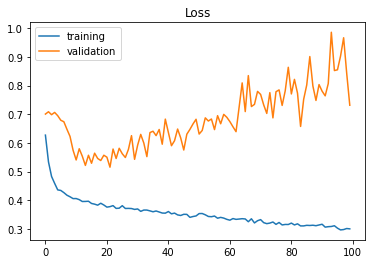

In [8]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.legend();

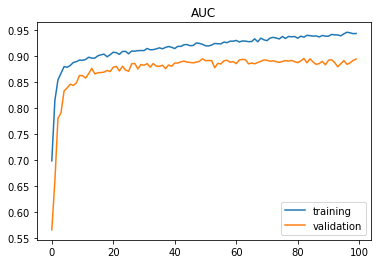

In [9]:
plt.figure()
plt.plot(history.history['auc'], label='training')
plt.plot(history.history['val_auc'], label='validation')
plt.title('AUC')
plt.legend();

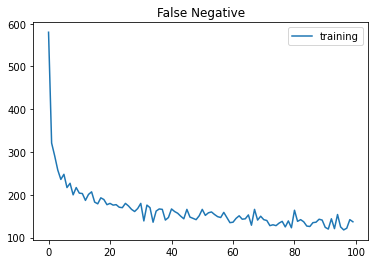

In [10]:
plt.figure()
plt.plot(history.history['false_negatives'], label='training')
plt.title('False Negative')
plt.legend();

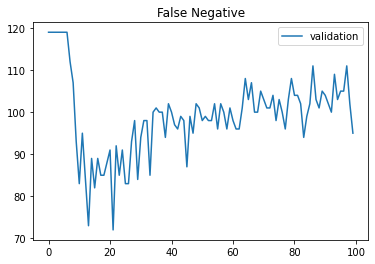

In [11]:
plt.figure()
plt.plot(history.history['val_false_negatives'], label='validation')
plt.title('False Negative')
plt.legend();

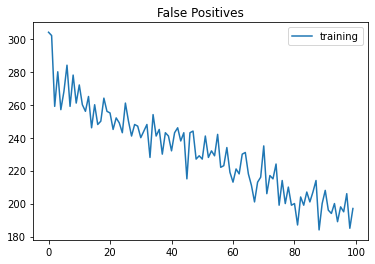

In [12]:
plt.figure()
plt.plot(history.history['false_positives'], label='training')
plt.title('False Positives')
plt.legend();

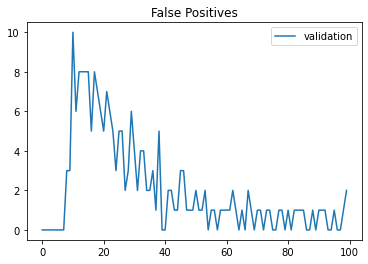

In [13]:
plt.figure()
plt.plot(history.history['val_false_positives'], label='validation')
plt.title('False Positives')
plt.legend();

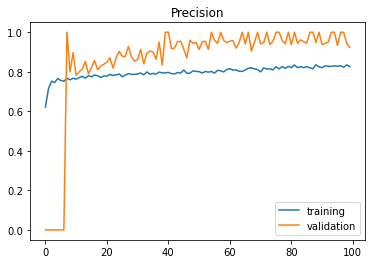

In [14]:
plt.figure()
plt.plot(history.history['precision'], label='training')
plt.plot(history.history['val_precision'], label='validation')
plt.title('Precision')
plt.legend();

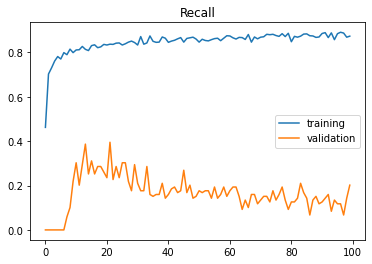

In [15]:
plt.figure()
plt.plot(history.history['recall'], label='training')
plt.plot(history.history['val_recall'], label='validation')
plt.title('Recall')
plt.legend();

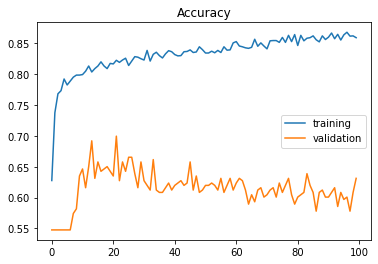

In [16]:
plt.figure()
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.legend();